## $\color{red}{\text{Lecture Overview}}$
1. **Multiple Linear Regression**
2. **Developing the Analytic Task**
3. **Data Transformation**
4. **Data Visualization**
5. **Data Modeling**

## $\color{red}{\text{Multiple Linear Regression}}$

1. Used to describe a linear relationship between a dependent variable and independent variables
2. **Simple linear regression** will be of the form: **$y=b_0 + b_1X_1$**
3. **Multiple linear regression** will be of the form: $y=b_0 + b_1X_1 + ... + b_kX_k $
    - $y$ is the **dependent variable** and $X_1, X_2, ..., X_k$ are the **independent variables**
4. The goal is to determine the coefficients $b_0, b_1, ..., b_k$ in order to reduce prediction error

## $\color{red}{\text{Import Required Packages}}$

In [78]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pylab as plt

## $\color{red}{\text{Import Data}}$

In [79]:
df = pd.read_csv('/Users/dB/Documents/repos/github/bint-capstone/notebooks/data/housingData.csv')
df.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,7129300520,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,221900.0
1,6414100192,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,538000.0
2,5631500400,20150225T000000,2,1.00,770,10000,1.0,0,0,3,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,180000.0
3,2487200875,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,604000.0
4,1954400510,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,510000.0


## $\color{red}{\text{Analytic Task}}$
1. Using the housing data, build a **multiple linear regression model** to predict **price**
2. Perform data transformation methods wherever needed
3. Perform data visualization tasks to develop a preliminary understanding of **price**
4. Develop a model to predict **price**
5. Assess the robustness of the model
6. Interpret the model for insights

## $\color{red}{\text{Data Transformation}}$


### $\color{blue}{\text{Missing Value Analysis}}$

- Check missing values in the data

In [80]:
def pct_missing(data):
    return data.isnull().sum().divide(len(data)).sort_values(ascending=False)

pct_missing(df)

id               0.0
sqft_above       0.0
sqft_lot15       0.0
sqft_living15    0.0
long             0.0
lat              0.0
zipcode          0.0
yr_renovated     0.0
yr_built         0.0
sqft_basement    0.0
grade            0.0
date             0.0
condition        0.0
view             0.0
waterfront       0.0
floors           0.0
sqft_lot         0.0
sqft_living      0.0
bathrooms        0.0
bedrooms         0.0
price            0.0
dtype: float64

In [81]:
print(f'There are {df.isna().sum().sum()} missing values in the data')

There are 0 missing values in the data


### $\color{blue}{\text{Multicollinearity}}$

1. Using a correlation plot, find variables with strong association with the dependent variable, **price**
2. **Multicollinearity** occurs when variables have similar information
    - Variables with a correlation greater than 0.70 are considered to have similar information
    - One of the variables should not be included in the analysis
3. Which variables are closely related to each other?

In [82]:
from dython.nominal import associations
import seaborn as sns

def my_corrplot(df, dep_var):

    # create a correlation matrix of all predictor variables using 'associations'
    corr_matrix = associations(dataset=df.drop('price', axis=1), compute_only=True)['corr']

    # Mask upper triangle of the corr heatmap ???
    mask_upper = np.triu(np.ones_like(corr_matrix, dtype=bool))

    # Plot
    plt.figure(figsize=(12,12))
    sns.heatmap(corr_matrix, annot=True, mask=mask_upper, fmt='.2f', vmin=-1, vmax=1)

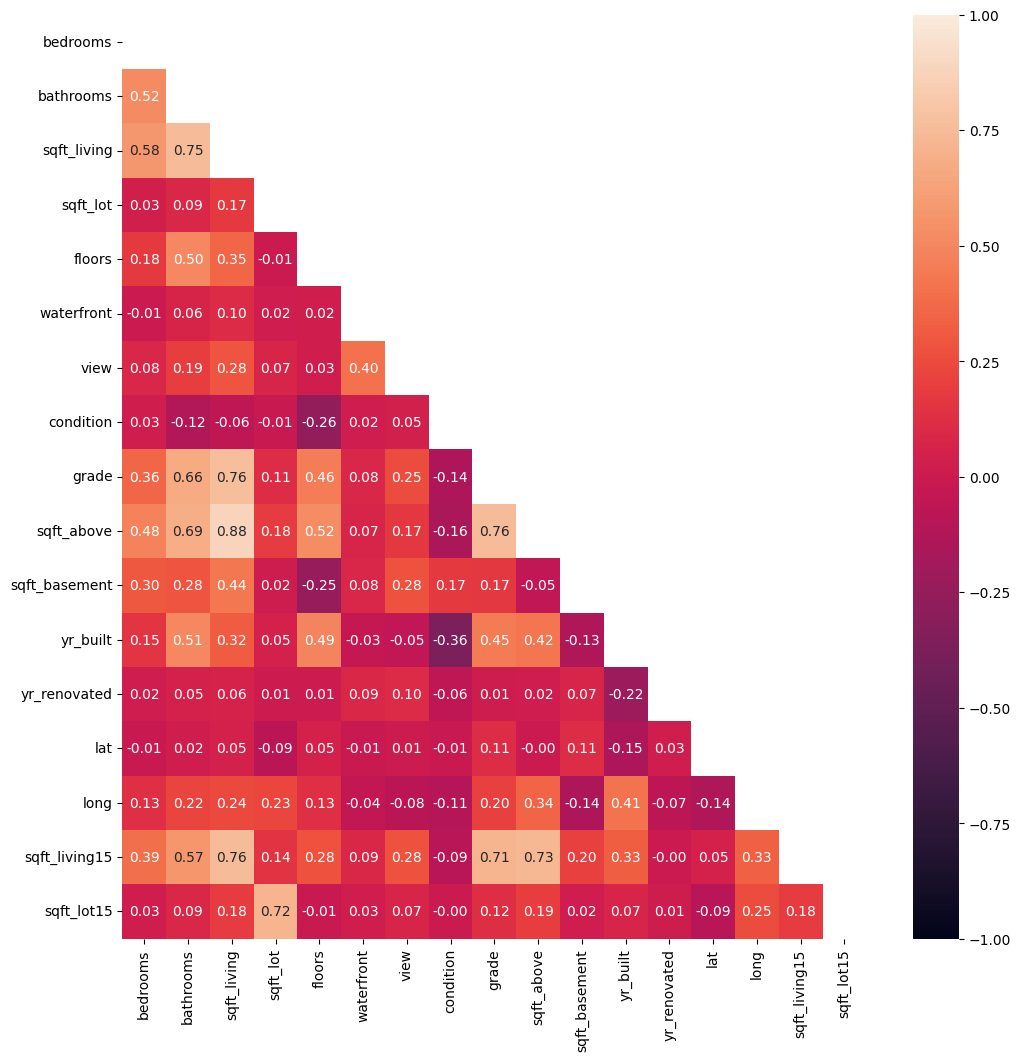

In [83]:
to_drop = ['id', 'date','zipcode']
new_df = df.drop(to_drop, axis=1)

my_corrplot(new_df, new_df['price'])

In general, Multicollinear variables are taken out of the data if you have values above .7!

How do we choose which one to remove?

### $\color{blue}{\text{Removing Colinear Variables}}$
- If correlation between variables are greater than 0.7, one of the variables should be removed

In [84]:
def removeHighCorrFeatures(data,dep_var, thresh):

    # Compute a corr_matrix and obtain abs value of the corr. Recall corrs are in the range [-1,1]
    corr_matrix = associations(dataset=data.drop(dep_var, axis=1), compute_only=True)['corr'].abs()

    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # for loop to drop all features where abs(correlation) > threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column]>thresh)]

    # assign to df
    new_data = data.drop(to_drop, axis=1)

    return new_data

In [85]:
no_multicollinearity = removeHighCorrFeatures(new_df, 'price', .7)

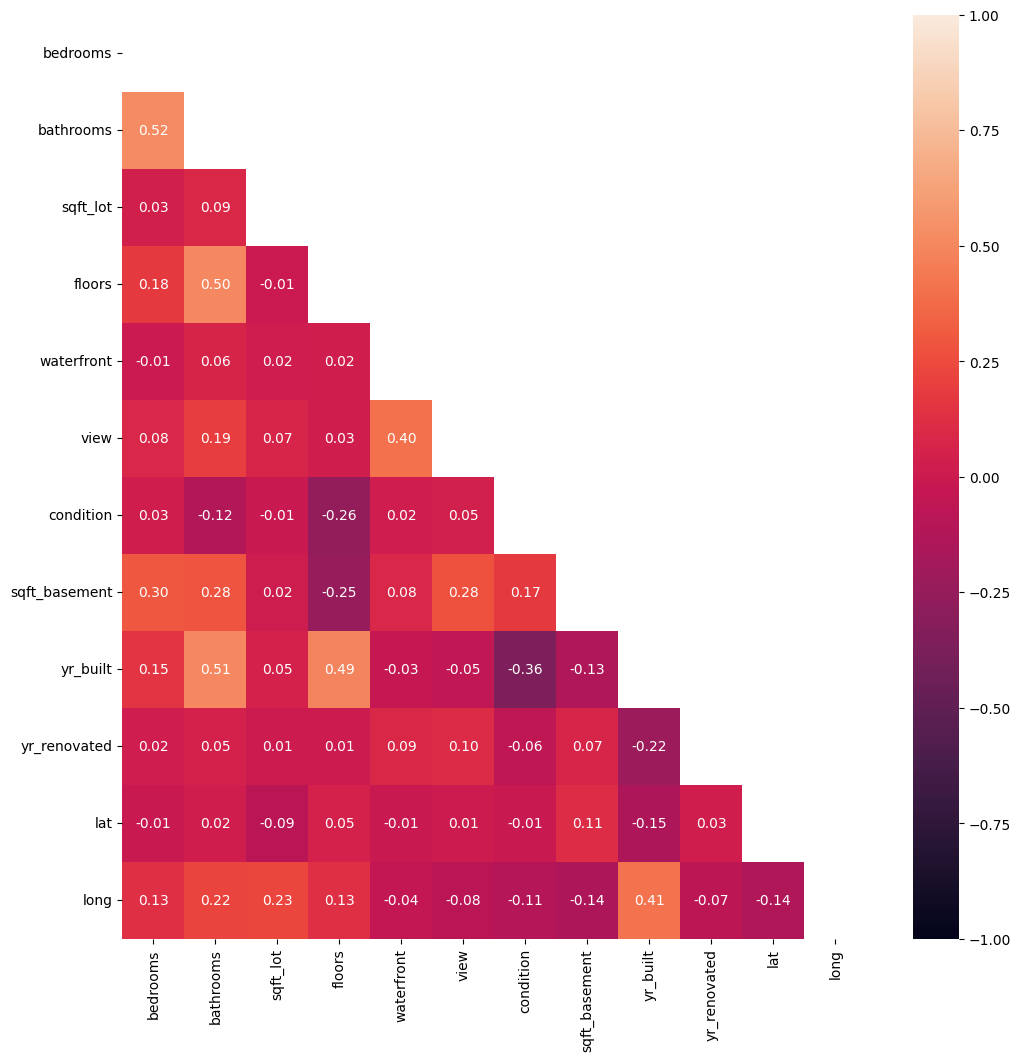

In [86]:
my_corrplot(no_multicollinearity, no_multicollinearity['price'])

### $\color{blue}{\text{Removing Near Zero-Variance Variables}}$
- Some variables have little or no variation. They do not add much value to the model

In [87]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

vThreshold = VarianceThreshold(threshold=.1)
vThreshold.fit_transform(no_multicollinearity)

# get vars with greater variance
vars = no_multicollinearity.columns[vThreshold.get_support()]

# subset data for variables with greater variance
no_mc_or_low_var = no_multicollinearity[vars]

# Fit the Model
df_std = StandardScaler().fit_transform(no_mc_or_low_var)
cleaned = pd.DataFrame(df_std, columns=no_mc_or_low_var.columns)

# Now we have a fully preprocessed df for the model-building step

In [88]:
cleaned.head()

,bedrooms,bathrooms,sqft_lot,floors,view,condition,sqft_basement,yr_built,yr_renovated,price
0,-0.398737,-1.447464,-0.228321,-0.915427,-0.305759,-0.629187,-0.658681,-0.544898,-0.210128,-0.866419
1,-0.398737,0.175607,-0.189885,0.936506,-0.305759,-0.629187,0.245141,-0.681079,4.746678,-0.005940
2,-1.473959,-1.447464,-0.123298,-0.915427,-0.305759,-0.629187,-0.658681,-1.293892,-0.210128,-0.980478
3,0.676485,1.149449,-0.244014,-0.915427,-0.305759,2.444294,1.397515,-0.204446,-0.210128,0.173723
4,-0.398737,-0.149007,-0.169653,-0.915427,-0.305759,-0.629187,-0.658681,0.544548,-0.210128,-0.082161


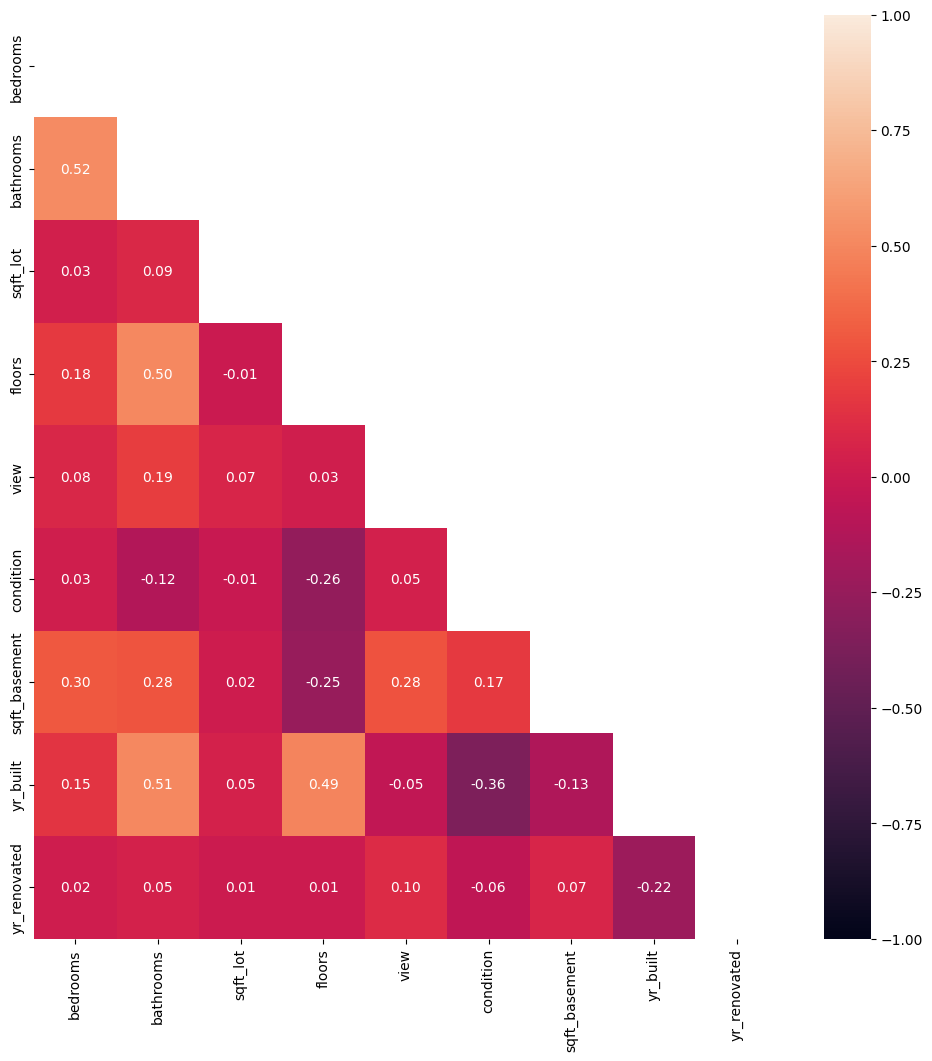

In [89]:
my_corrplot(cleaned, 'price')

## $\color{red}{\text{Model Building}}$

### $\color{blue}{\text{Data Partitioning}}$

1. Identify dependent and independent variables
2. Partition the data such that 80% is used for training and 20% is used for testing

In [90]:
from sklearn.model_selection import train_test_split

X = cleaned.loc[:, cleaned.columns != 'price']
y = cleaned.loc[:, cleaned.columns == 'price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2142)

In [91]:
X.head()

,bedrooms,bathrooms,sqft_lot,floors,view,condition,sqft_basement,yr_built,yr_renovated
0,-0.398737,-1.447464,-0.228321,-0.915427,-0.305759,-0.629187,-0.658681,-0.544898,-0.210128
1,-0.398737,0.175607,-0.189885,0.936506,-0.305759,-0.629187,0.245141,-0.681079,4.746678
2,-1.473959,-1.447464,-0.123298,-0.915427,-0.305759,-0.629187,-0.658681,-1.293892,-0.210128
3,0.676485,1.149449,-0.244014,-0.915427,-0.305759,2.444294,1.397515,-0.204446,-0.210128
4,-0.398737,-0.149007,-0.169653,-0.915427,-0.305759,-0.629187,-0.658681,0.544548,-0.210128


In [92]:
y.head()

,price
0,-0.866419
1,-0.005940
2,-0.980478
3,0.173723
4,-0.082161


### $\color{blue}{\text{Model Fitting and Result}}$

In [93]:
import statsmodels.api as sm

train_X = sm.add_constant(X_train)

model = sm.OLS(y_train, train_X).fit()

model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     1386.
Date:                Thu, 27 Feb 2025   Prob (F-statistic):               0.00
Time:                        14:47:39   Log-Likelihood:                -19802.
No. Observations:               17290   AIC:                         3.962e+04
Df Residuals:                   17280   BIC:                         3.970e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0017      0.006      0.294      0.769      -0.010       0.013
bedrooms          0.0156      0.007      2.269      0.023       0.002       0.029
bathrooms         0.4672      0.009     50.072      0.000       0.449       0.485
sqft_lot          0.0425      0.006      7.515      0.000       0.031       0.054
floors            0.1547      0.008     19.885      0.000       0.139       0.170
view              0.2530      0.006     41.397      0.000       0.241       0.265
condition         0.0259      0.006      4.041      0.000       0.013       0.038
sqft_basement     0.1149      0.007     15.830      0.000       0.101       0.129
yr_built         -0.2192      0.008    -27.133      0.000      -0.235      -0.203
yr_renovated      0.0146      0.006      2.397      0.017       0.003       0.026
==============================================================================
Omnibus:                    12896.655   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           643691.763
Skew:                           3.098   Prob(JB):                         0.00
Kurtosis:                      32.242   Cond. No.                         3.11
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

For the run on 2/27/25 with seed 2142 (`random_state` in the TT split), we get the equation:

$$
\begin{align*}
Y = .0017 + .0155 * x_1 + .4672 * x_2 + .0425 * x_3 + .1547 * x_4 + .2530 * x_5 + .0259 * x_6 + .1149 * x_7 - .2192 * x_8 + .0146 * x_9
\end{align*}
$$

1. Explain the model coefficient. <br>
In this case, I will explain the coefficient of the 'bedrooms' variable
  - For one unit increase in **(ind. variable)**, the **(dep variable)** increases/ decreases by **(the coefficient of the ind variable)**, while holding all the independet variables constant
  - For one unit increase in bedrooms, the price increases by 0.0121, while holding all the independet variables constant.

------
1. Explain the R-squared
- The independent variables, explains (r-quared value) of the (dependent variable)
- The independent variables, explains 43% of price


### $\color{blue}{\text{Model Prediction}}$

- Predict the **price** of the testing data as a function of the independent variables

In [94]:
test_x = sm.add_constant(X_test)

pred_train = model.predict(train_X)
pred_test = model.predict(test_x)

## $\color{red}{\text{Model Diagnostics}}$

### $\color{blue}{\text{QQ Plot}}$

We assume that errors, or residuals are normally distributed

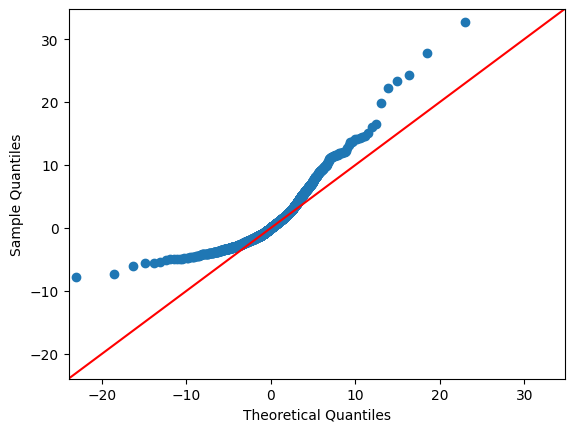

In [95]:
import scipy.stats as stats

res = model.resid
fig = sm.qqplot(res, stats.t, fit=True, line='45')
plt.show()

### $\color{blue}{\text{Error Calculations}}$

- Mean Error (ME), Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE), Mean Percentage Error (MPE)
- Mean Absolute Percentage Error (MAPE)

In [96]:
from dmba import regressionSummary

print('Training Data')
regressionSummary(y_train, pred_train)
print('Testing Data')
regressionSummary(y_test, pred_test)

Training Data

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 0.7606
            Mean Absolute Error (MAE) : 0.4959
          Mean Percentage Error (MPE) : 119.7064
Mean Absolute Percentage Error (MAPE) : 493.9588
Testing Data

Regression statistics

                      Mean Error (ME) : -0.0085
       Root Mean Squared Error (RMSE) : 0.7500
            Mean Absolute Error (MAE) : 0.4823
          Mean Percentage Error (MPE) : 113.0976
Mean Absolute Percentage Error (MAPE) : 422.6465
